# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [63]:
! git clone https://github.com/yango4014/assignment4

fatal: destination path 'assignment4' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree

1. Load cars_hw.csv. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.

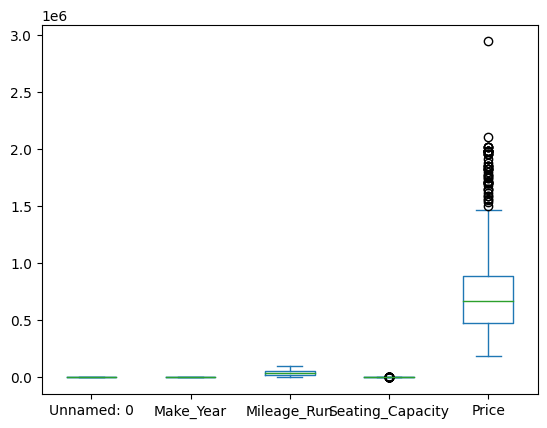

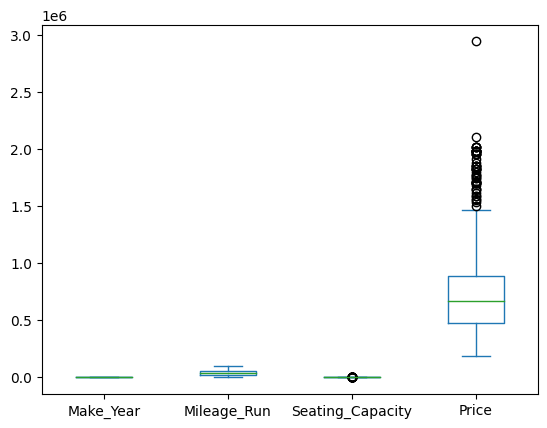

In [ ]:
#1
df = pd.read_csv('assignment4/data/cars_hw.csv', encoding='latin1')
df.plot.box() #original boxplots to look at outliers
X=df.drop('Unnamed: 0', axis=1) #dropping unnamed bc it's irrelevant
X.plot.box() #shows price and potentially mileage as columns w/ outliers
df = X


<Axes: xlabel='Price', ylabel='Density'>

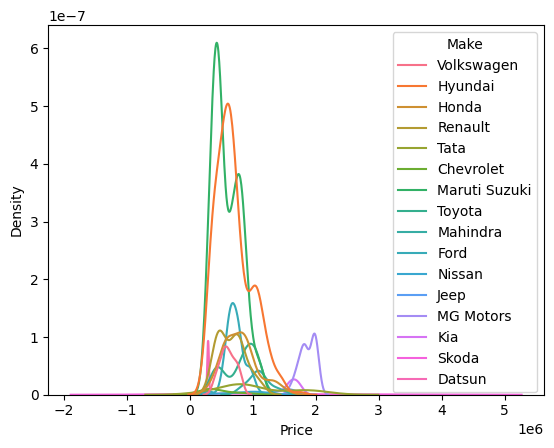

In [ ]:
sns.kdeplot(data=df, x='Price', hue='Make')

<Axes: xlabel='Make', ylabel='Price'>

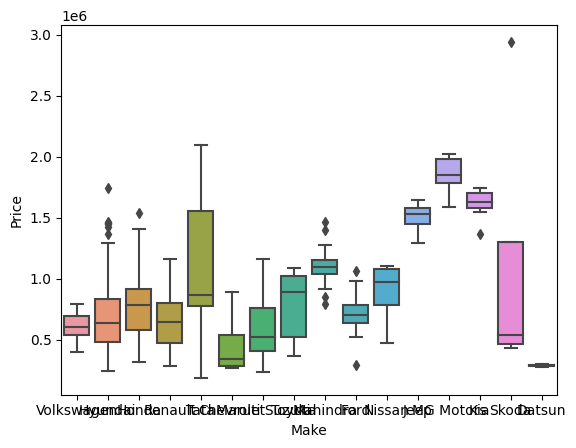

In [ ]:
sns.boxplot(data=df, x='Make', y='Price') #original boxplots


<ipython-input-7-b9b864389fdc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-7-b9b864389fdc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker


<Axes: >

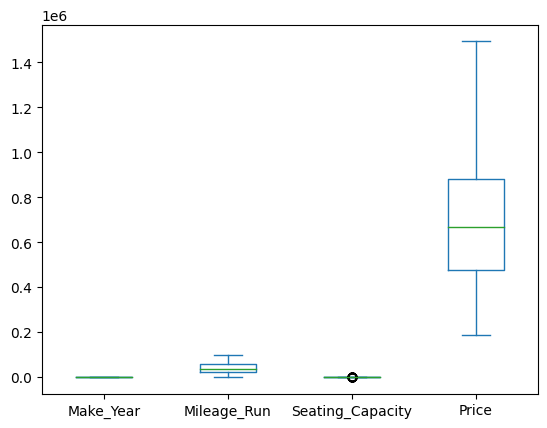

In [ ]:
#will windsorize price due to outliers
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

df['Price'] = windsorize(df['Price'])
df.plot.box()

2. Summarize the Price variable and create a kernel density plot. Use .groupby() and .describe() to summarize prices by brand (Make). Make a grouped kernel density plot by Make. Which car brands are the most expensive? What do prices look like in general?

<Axes: xlabel='Make', ylabel='Price'>

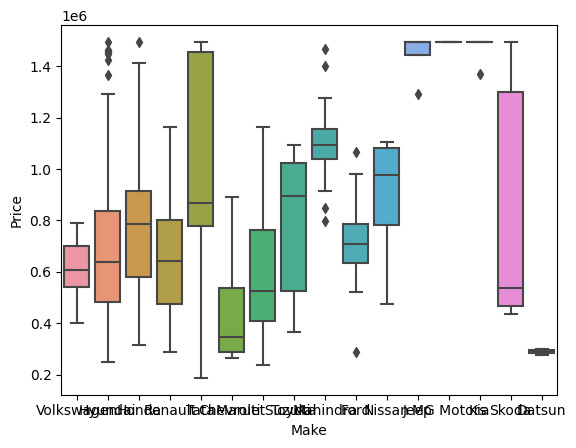

In [ ]:
sns.boxplot(data=df, x='Make', y='Price') #boxplots after windsorizing
#seems like three car makes were cut off due to windsorizing which likely means they aren't as representative of price amongst the other car makes
#car makes are jeep, mg motors, and kia

In [ ]:
#2
var = 'Price'
group = 'Make'
df.loc[:,[var,group]].groupby(group).describe()

Price                                                      \
               count          mean            std        min         25%   
Make                                                                       
Chevrolet        6.0  4.535000e+05  246606.366503   267000.0   288500.00   
Datsun           3.0  2.896667e+05   10503.967504   279000.0   284500.00   
Ford            52.0  7.211731e+05  140927.699605   290000.0   635000.00   
Honda           73.0  7.983818e+05  264893.305869   316000.0   581000.00   
Hyundai        305.0  6.910783e+05  276437.697587   248000.0   485000.00   
Jeep             4.0  1.442906e+06  101937.500000  1290000.0  1442906.25   
Kia              8.0  1.478266e+06   44149.979650  1369000.0  1493875.00   
MG Motors       35.0  1.493875e+06       0.000000  1493875.0  1493875.00   
Mahindra        18.0  1.100167e+06  175549.305961   796000.0  1037000.00   
Maruti Suzuki  293.0  5.887850e+05  216019.860943   237000.0   411000.00   
Nissan           4.0  8.842500e+05  289559.867155   475000.0   782500.00   
Renault         68.0  6.625735e+05  214827.338943   287000.0   475000.00   
Skoda            5.0  8.465750e+05  508014.114592   436000.0   466000.00   
Tata            23.0  9.560978e+05  405929.901788   188000.0   779500.00   
Toyota          50.0  8.003400e+05  246689.973986   368000.0   526250.00   
Volkswagen      29.0  6.058276e+05  119831.151735   402000.0   542000.00   

                                                
                     50%        75%        max  
Make                                            
Chevrolet       345500.0   537500.0   892000.0  
Datsun          290000.0   295000.0   300000.0  
Ford            707500.0   787000.0  1066000.0  
Honda           785000.0   915000.0  1493875.0  
Hyundai         638000.0   837000.0  1493875.0  
Jeep           1493875.0  1493875.0  1493875.0  
Kia            1493875.0  1493875.0  1493875.0  
MG Motors      1493875.0  1493875.0  1493875.0  
Mahindra       1094500.0  1157000.0  1465000.0  
Maruti Suzuki   527000.0   764000.0  1163000.0  
Nissan          978000.0  1079750.0  1106000.0  
Renault         644000.0   801000.0  1164000.0  
Skoda           538000.0  1299000.0  1493875.0  
Tata            869000.0  1456437.5  1493875.0  
Toyota          894000.0  1023000.0  1092000.0  
Volkswagen      607000.0   699000.0   790000.0

<ipython-input-10-a89b8310f3c9>:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=var, hue=group)


<Axes: xlabel='Price', ylabel='Density'>

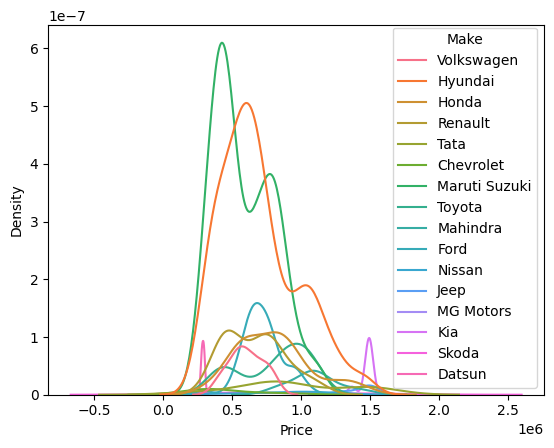

In [ ]:
sns.kdeplot(data=df, x=var, hue=group)

From the density plot, it seems like MG Motors has the highest mean though the density plot indicates that Skoda has the highest prices. I'm assuming that because MG Motors have cars that are fairly all on the higher side, by windsorizing, the smallest and largest value become very similar values which is why there isn't a very noticeable peak for MG Motors in the density plot. The prices in geenral congregate around 500,000, specifically the Maruti Suzuki and Hyundai car makes. I created a density plot and box plots of the original data before windsorizing just to see what the changes were like.

3. Split the data into an 80% training set and a 20% testing set.

In [ ]:
#3 Split the data into an 80% training set and a 20% testing set.

y=df['Price']
vars = ['Color','Seating_Capacity','Body_Type','Make','Make_Year','Mileage_Run','Fuel_Type','Transmission','Transmission_Type']
X=df.loc[:,vars]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)


Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the  R2  and RMSE on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the  R2  and RMSE on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the  R2  and RMSE on the test set? Does the joint model perform better or worse, and by home much?

In [ ]:
#4
print(df.dtypes, '\n')

#numeric variables
num_vars = ['Make_Year','Mileage_Run','Seating_Capacity']
X = df.loc[:,num_vars]

#splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

#fitting data
reg = LinearRegression().fit(X_train, y_train)

print('Numeric R-Squared: ', reg.score(X,y)) #r2

predict=reg.predict(X_test)
print('Numeric RMSE: ', np.sqrt(mean_squared_error(y_test,predict)), '\n') #rmse

#categorical variables
cat_vars = ['Make', 'Color', 'Body_Type', 'No_of_Owners', 'Fuel_Type','Transmission','Transmission_Type']

#new matrix
drop_col = ['Price', 'Make_Year','Mileage_Run','Seating_Capacity']
cat_df = pd.get_dummies(df, columns=cat_vars, drop_first = True)
cat_X = cat_df.drop(columns=drop_col)

#splitting
X_train, X_test, y_train, y_test = train_test_split(cat_X,y,test_size=.2,random_state=100)

#fitting data
reg = LinearRegression().fit(X_train, y_train)

print('Categorical R-Squared: ', reg.score(cat_X,y)) #r2

predict=reg.predict(X_test)
print('Categorical RMSE: ', np.sqrt(mean_squared_error(y_test,predict)),'\n') #rmse

#joint
joint_X = pd.concat([X, cat_X], axis =1)

#splitting
X_train, X_test, y_train, y_test = train_test_split(joint_X,y,test_size=.2,random_state=100)

#fitting data
reg = LinearRegression().fit(X_train, y_train)

print('Categorical R-Squared: ', reg.score(joint_X,y)) #r2

predict=reg.predict(X_test)
print('Categorical RMSE: ', np.sqrt(mean_squared_error(y_test,predict))) #rmse


Make                 object
Make_Year             int64
Color                object
Body_Type            object
Mileage_Run           int64
No_of_Owners         object
Seating_Capacity      int64
Fuel_Type            object
Transmission         object
Transmission_Type    object
Price                 int64
dtype: object 

Numeric R-Squared:  0.35263359346532086
Numeric RMSE:  249410.73903136648 

Categorical R-Squared:  0.7276315943410362
Categorical RMSE:  159942.51061204477 

Categorical R-Squared:  0.8383931553767613
Categorical RMSE:  121463.48426069801


Between numeric and categorical, it seems like categorical model performs better on test set as the r-squared value is closer to 1. In addition, the categorical regression model had a lower root mean squared error value.

Yippe!! The joint model seems to be best of the three with the highest r-squared and lower RMSE value. I don't think it's significantly better than the categorical model, but it's definitely a much better fit than the numeric model baesd on the r-squared value.

5. Use the PolynomialFeatures function from sklearn to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the  R2  and RMSE change? At what point does  R2  go negative on the test set? For your best model with expanded features, what is the  R2  and RMSE? How does it compare to your best model from part 3?


In [ ]:
# Expand features
def expand(vars):
  expander = PolynomialFeatures(degree=vars,include_bias=False) # Create the expander
  Z = expander.fit_transform(joint_X) # Pass the df into the expander to get powers/interactions of x and y
  names = expander.get_feature_names_out() # Get the names of these variables
  zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
  X_train, X_test, y_train, y_test = train_test_split(zdf,y,test_size=.2,random_state=100)
  reg = LinearRegression().fit(X_train, y_train)
  print ('Degrees: ', vars,'\n')
  print ('R-Squared: ', reg.score(zdf,y)) #r2
  predict=reg.predict(X_test)
  print ('RMSE: ', np.sqrt(mean_squared_error(y_test,predict))) #rmse
  return '\n'

print (expand(1))
print (expand(2))
print (expand(3))


Degrees:  1 

R-Squared:  0.8383931553767613
RMSE:  121463.48426069801


Degrees:  2 

R-Squared:  -24.857197870134346
RMSE:  3528840.1593754143


Degrees:  3 

R-Squared:  -4413.250607246389
RMSE:  46146441.60923671




Model is still best when we don't introduce new features. The R squared value becomes negative when degree goes from 1 to 2 and becomes significantly more negative when going from 2 to 3. The mean squared value also gets higher as the degrees get larger. Thus, the best model with expanded features is the one with degrees of 2. It's not as good as the joint model from question 4 due to it's more negative r-squared value and larger mean squared error value.

6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

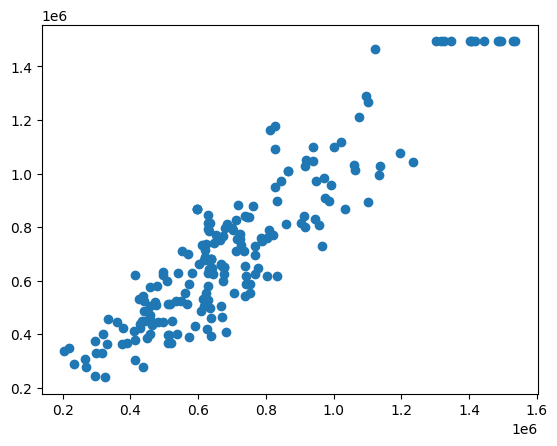

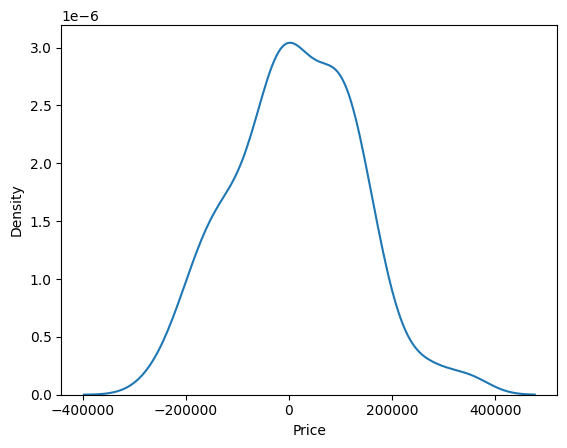

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(joint_X,y,test_size=.2,random_state=100)

#fitting data
reg = LinearRegression().fit(X_train, y_train)

#predicted values
y_hat = reg.predict(X_test)
residuals = y_test - y_hat

#predicted values vs true
plt.scatter(x=y_hat,y=y_test)
plt.show()

#residual plot
sns.kdeplot(residuals)
plt.show()


 The predicted values and true values line up along the diagonal, towards the positive direction.They honestly look very strong correlated. For the kernel density plot, the residuals do look roughly bell-shaped around zero.

 The model seems to have good fit with the data provided, given that the reisduals are bell-shaped and that the scatterplot show a strong correlation. The weakness could be that it's fitted for the data provided, so it may not be best at predicting outcomes for new data. There is a chance that this model is overfitted which means it may have poor generalization with new data. In addition, the top of the scatterplot show a plataeu which may be due to the initial windsorizing which also means that the model may not be best at extrapolating data as price increases.

7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)), and compute the  R2  and RMSE on the test set of a variety of depths. What depth tree gives the best results?

Depth:  6
Accuracy:  0.5 

0.8140847039577941
133669.25057694066


Depth:  8
Accuracy:  0.5 

0.8160372942309976
132965.46179983122


Depth:  9
Accuracy:  0.5 

0.8304660987223557
127644.53628341669


Depth:  10
Accuracy:  0.5 

0.7900119624584833
142059.80995256422




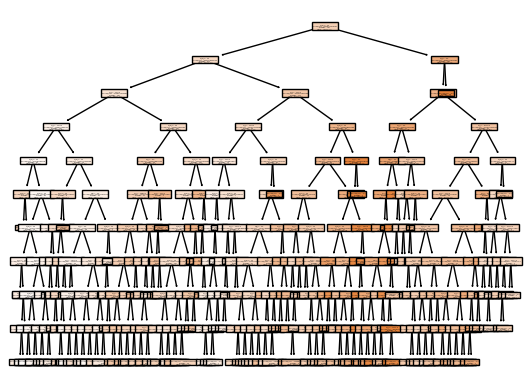

In [ ]:
def tree(depth):
  ## Split the Sample into Training and Testing Sets:
  X_train, X_test, y_train, y_test = train_test_split(joint_X,y,test_size=.2,random_state=104)

  ## Fit the Model
  from sklearn import tree # Import the tree classifier
  cart = tree.DecisionTreeRegressor(max_depth = depth) # Create a regression object
  cart = cart.fit(X_train, y_train) # Fit the classifier

  #visualize
  tree.plot_tree(cart, filled = True)
  ## Make Predictions on the Test Set
  y_hat = cart.predict(X_test)

  ## Confusion Matrix
  tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
  acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
  print("Depth: ", depth)
  print('Accuracy: ', acc, '\n')
  pd.crosstab(y_test,y_hat)

  print(cart.score(X_test, y_test))

  predict = cart.predict(X_test)
  print(np.sqrt(mean_squared_error(y_test, predict)))

  return '\n'

print(tree(6))
print(tree(8))
print(tree(9))
print(tree(10))


It seems like a tree with depth 9 gives the best fit model given that it's r-squared value is closest to 1. In addition, it has the lowest root mean squared error.

8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?

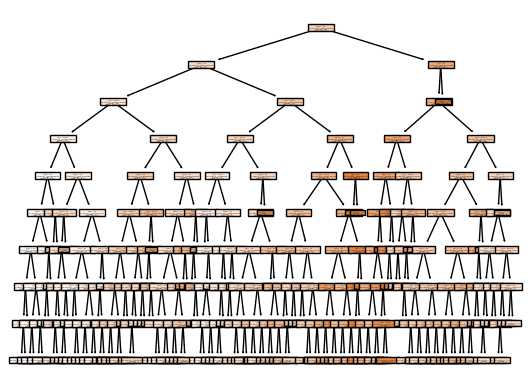

In [ ]:
## Split the Sample into Training and Testing Sets:
X_train, X_test, y_train, y_test = train_test_split(joint_X,y,test_size=.2,random_state=104)

## Fit the Model
from sklearn import tree # Import the tree classifier
cart = tree.DecisionTreeRegressor(max_depth = 9) # Create a regression object
cart = cart.fit(X_train, y_train) # Fit the regression

#visualize
tree.plot_tree(cart, filled = True)

## Make Predictions on the Test Set
y_hat = cart.predict(X_test)

## Confusion Matrix
tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy

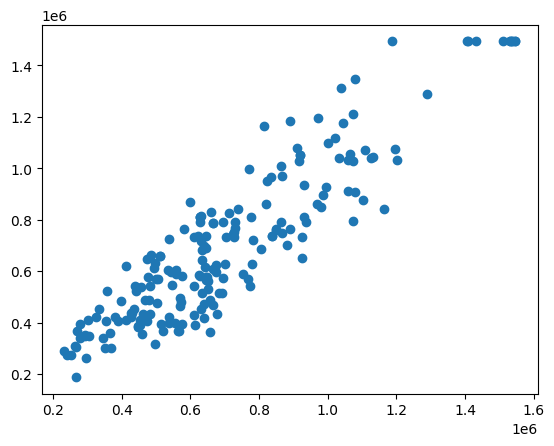

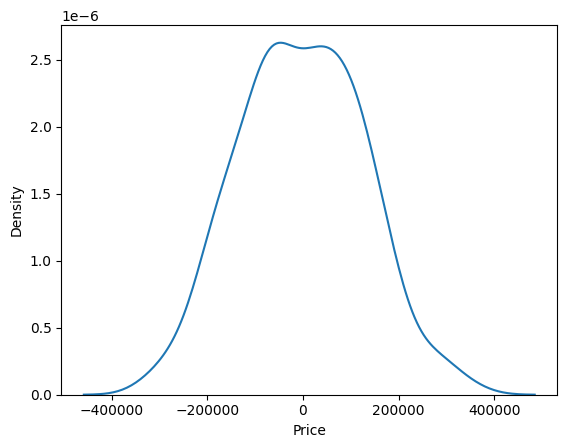

In [ ]:
#predicted values
y_hat = reg.predict(X_test)
residuals = y_test - y_hat

#predicted values vs true
plt.scatter(x=y_hat,y=y_test)
plt.show()

#residual plot
sns.kdeplot(residuals)
plt.show()

The predicted values and true values line up along the diagonal in the scatterplot. The residuals look roughly bell-shaped around zero.

9. Which model --- linear model or classification and regression tree --- has better performance on the test set?

The linear model has better performance based on the r-squared value, but it is only ever so slightly better. Overall, it seems like both models have similar performance though the tree takes a second to run due to the larger depth.

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

1. Load the contraceptiveMethodChoice.csv data. Tabulate the method variable (i.e. .value_counts()). 1 corresponds to No Contraception, 3 corresponds to Short Term (e.g. condoms, birth control pills), and 2 corresponds to Long Term (e.g. IUD, sterilization). Cross tabulate method and numberChildren. Do couples that use birth control tend to have more children than those who don't?

In [73]:
df = pd.read_csv('assignment4/data/contraception_hw.csv', encoding='latin1')
print(df.head(),'\n')

#method tabulation
print(df['method'].value_counts(), '\n')

#cross tabulation
print(pd.crosstab(df['method'],df['numberChildren']))

#1 = none
#2 = long term
#3 = short term

   Unnamed: 0  age  edu  edu_spouse  numberChildren  religion  working  \
0           1   24    2           3               3         1        1   
1           2   45    1           3              10         1        1   
2           3   43    2           3               7         1        1   
3           4   42    3           2               9         1        1   
4           5   36    3           3               8         1        1   

   spouse_occupation  standardOfLivingIndex  mediaExposure  method  
0                  2                      3              0       1  
1                  3                      4              0       1  
2                  3                      4              0       1  
3                  3                      3              0       1  
4                  3                      2              0       1   

1    629
3    511
2    333
Name: method, dtype: int64 

numberChildren  0    1    2    3   4   5   6   7   8   9   10  11  12  13  16
metho

Overall, there are more couples that don't use contraceptions that have children, but the actual number of children each couple has differs a bit. We see that couples who do use some sort of contraception, especially short-term, have a larger number of children. To get more specific analysis of this, I would want to find the average number of children couples tend to have within each method and see which method has couples that have more children.

2. Split the sample into ~80% training data and ~20% testing data.


In [74]:
y=df['method']
vars = ['age','edu','edu_spouse','numberChildren','religion','working','spouse_occupation','standardOfLivingIndex','mediaExposure']
X=df.loc[:,vars]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.

[Text(0.4230769230769231, 0.875, 'x[3] <= 0.5\nsquared_error = 0.763\nsamples = 1178\nvalue = 1.928'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 18.0\nsquared_error = 0.096\nsamples = 81\nvalue = 1.049'),
 Text(0.07692307692307693, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 3.0'),
 Text(0.23076923076923078, 0.375, 'x[6] <= 3.5\nsquared_error = 0.049\nsamples = 80\nvalue = 1.025'),
 Text(0.15384615384615385, 0.125, 'squared_error = 0.0\nsamples = 78\nvalue = 1.0'),
 Text(0.3076923076923077, 0.125, 'squared_error = 1.0\nsamples = 2\nvalue = 2.0'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 37.5\nsquared_error = 0.751\nsamples = 1097\nvalue = 1.993'),
 Text(0.5384615384615384, 0.375, 'x[3] <= 2.5\nsquared_error = 0.75\nsamples = 778\nvalue = 2.132'),
 Text(0.46153846153846156, 0.125, 'squared_error = 0.794\nsamples = 374\nvalue = 1.992'),
 Text(0.6153846153846154, 0.125, 'squared_error = 0.674\nsamples = 404\nvalue = 2.262'),
 Text(0.8461538461538461, 0.375, 'x[1] <= 3.5\nsquared_e

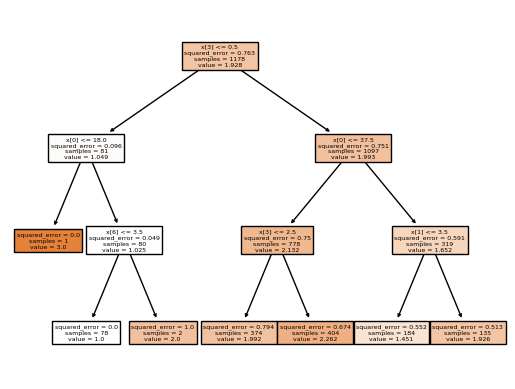

In [82]:
## Fit the Model
from sklearn import tree # Import the tree classifier
cart = tree.DecisionTreeRegressor(max_depth = 3) # Create a regression tree
cart = cart.fit(X_train, y_train)

## Make Predictions on the Test Set
y_hat = cart.predict(X_test)

#visualize
tree.plot_tree(cart, filled = True)


It seems like the values the model takes are the numbers we assigned the categorical variables. The model treats our categorical values as numeric which is why we get predicted values that are decimals which aren't representative of the actual data where we have 1,2,3...etc that represents specific observations. This model does not make sense because it does not actually represent what we're trying to look for in predicting contraceptive method since it takes the values as continuous values.

4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

[Text(0.21458796051814116, 0.9791666666666666, 'x[3] <= 0.5\ngini = 0.647\nsamples = 1178\nvalue = [502, 269, 407]'),
 Text(0.0437375745526839, 0.9375, 'x[0] <= 17.5\ngini = 0.052\nsamples = 75\nvalue = [73, 0, 2]'),
 Text(0.041749502982107355, 0.8958333333333334, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.04572564612326044, 0.8958333333333334, 'x[6] <= 3.5\ngini = 0.027\nsamples = 74\nvalue = [73, 0, 1]'),
 Text(0.0437375745526839, 0.8541666666666666, 'gini = 0.0\nsamples = 70\nvalue = [70, 0, 0]'),
 Text(0.04771371769383698, 0.8541666666666666, 'x[4] <= 0.5\ngini = 0.375\nsamples = 4\nvalue = [3, 0, 1]'),
 Text(0.04572564612326044, 0.8125, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.04970178926441352, 0.8125, 'gini = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(0.3854383464835984, 0.9375, 'x[1] <= 2.5\ngini = 0.654\nsamples = 1103\nvalue = [429, 269, 405]'),
 Text(0.1634256958250497, 0.8958333333333334, 'x[0] <= 37.5\ngini = 0.562\nsamples = 367\nvalue = [207, 

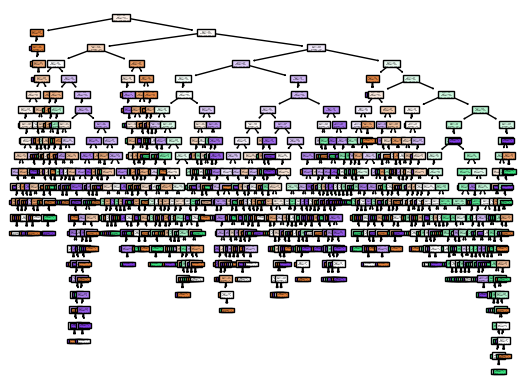

In [94]:
from sklearn import tree # Import the tree classifier

# Process data:
y = df['method']
drop_col = ['method','Unnamed: 0']
X = df.drop(drop_col, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

# Fit decision tree:
cart = tree.DecisionTreeClassifier() # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

## Make Predictions on the Test Set
y_hat = cart.predict(X_test)

# Visualize results:
tree.plot_tree(cart,filled=True)

The tree was really large in comparison to the regression tree and I think it was likely due to a greater number of variables present. If the tree were to be more visible, I would look at each node and see which indexes had a greater number of values which would indicate to me which group of people tend to use which types of contraceptives.

5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a  3×3  matrix instead of  2×2 .). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.

In [101]:
tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
print('Accuracy Overall: ', acc, '\n')
print(pd.crosstab(y_test,y_hat), '\n')

#accuracy for each contraceptive method
print('Method 1: ',78/(78+22+44))
print('Method 2: ',25/(16+25+25))
print('Method 3: ',35/(33+17+35))

Accuracy Overall:  0.7304964539007093 

col_0    1   2   3
method            
1       78  16  33
2       22  25  17
3       44  25  35 

Method 1:  0.5416666666666666
Method 2:  0.3787878787878788
Method 3:  0.4117647058823529


6. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

A linear probability model has an outcome that is a binary variable but because there are three categories for the contraceptive method, it no longer has a binary output, meaning we can't use the linear probability model to do this exercise.